## 1. Load data

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import pickle
import time
%matplotlib inline

## 2. Create function to generate dataset at specific size

In [2]:
def get_transforms(target_size):
    dataset_transforms = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.Pad( (29-target_size) // 2 ),
        transforms.ToTensor(),
    ])
    return dataset_transforms

def get_datasets(target_size=29):
    assert target_size <= 29 and target_size % 2 == 1
    dataset_transforms = get_transforms(target_size)
    train_dataset = datasets.MNIST('./data', train=True, transform=dataset_transforms, target_transform=None, download=True)
    
    train_size = int(0.8 * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    
    torch.manual_seed(42) # keep same seed everytime
    train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])
    test_dataset = datasets.MNIST('./data', train=False, transform=dataset_transforms, target_transform=None, download=True)
    return dict(train=train_dataset, valid=valid_dataset, test=test_dataset)

def show_tensor_image(image):
    plt.imshow(transforms.ToPILImage()(image), cmap='gray');
    
def get_dataloaders(data):
    dataloaders = dict(
        train=DataLoader(data['train'], batch_size=128, shuffle=True, num_workers=6),
        valid=DataLoader(data['valid'], batch_size=128, shuffle=False, num_workers=6),
        test=DataLoader(data['test'], batch_size=32, shuffle=False, num_workers=6),
    )
    return dataloaders

In [3]:
data = get_datasets(target_size=21)
len(data['train']), len(data['test'])

(48000, 10000)

In [4]:
x, y = data['train'][0]
type(x), type(y), x.shape

(torch.Tensor, int, torch.Size([1, 29, 29]))

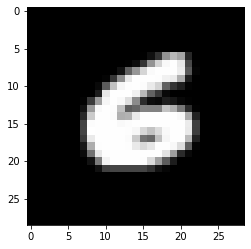

In [5]:
show_tensor_image(x)

## 3. Create model class and get_model function

In [6]:
class MCDNN1(nn.Module):
    def __init__(self):
        super(MCDNN1, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN2(nn.Module):
    def __init__(self):
        super(MCDNN2, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN3(nn.Module):
    def __init__(self):
        super(MCDNN3, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', nn.ReLU()),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class MCDNN4(nn.Module):
    def __init__(self):
        super(MCDNN4, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=3)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1)
    
class MCDNN(nn.Module):
    def __init__(self):
        super(MCDNN, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=3)),
            ('flatten', Flatten()),
            ('fc1', nn.Linear(in_features=40*3*3, out_features=150)),
            ('relu3', nn.ReLU()),
            ('fc2', nn.Linear(in_features=150, out_features=10)),
        ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

data = get_datasets(target_size=21)
dataloaders = get_dataloaders(data)
batch_x, batch_y = next(iter(dataloaders['train']))
print('first layer', MCDNN1()(batch_x).shape)
print('second layer', MCDNN2()(batch_x).shape)
print('third layer', MCDNN3()(batch_x).shape)
print('fourth layer', MCDNN4()(batch_x).shape)
print('final layer', MCDNN()(batch_x).shape)

first layer torch.Size([128, 20, 26, 26])
second layer torch.Size([128, 20, 13, 13])
third layer torch.Size([128, 40, 9, 9])
fourth layer torch.Size([128, 40, 3, 3])
final layer torch.Size([128, 10])


## 4. Create training function to train a model given ```dataloaders['train']``` and ```dataloaders['valid']```

In [7]:
def train_model(dataloaders, model, loss_func, optimizer, scheduler=None, device="cuda:0", epochs=1, save_func=None):
    
    def train_epoch():
        model.train()
        total_loss = 0
        for batch_x, batch_y in dataloaders['train']:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            loss = loss_func(pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None: scheduler.step()
            
            total_loss += loss.item()
        return total_loss / len(dataloaders['train'])
            
    def valid_epoch():
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in dataloaders['valid']:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                pred = model(batch_x)
                loss = loss_func(pred, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloaders['valid'])
    
    train_loss, valid_loss = [], []
    best_valid_loss = float('inf')
    pbar = tqdm(range(epochs), total=epochs)
    save_message = ''
    for epoch in pbar:
        train_loss.append(train_epoch())
        valid_loss.append(valid_epoch())
        pbar.set_description(f'epoch {epoch} current best {best_valid_loss:.3f} {save_message}')
        if valid_loss[-1] < best_valid_loss:
            best_valid_loss = valid_loss[-1]
            if save_func is not None:
                save_message = save_func(model)
                pbar.set_description(f'epoch {epoch} new best {valid_loss[-1]:.3f} {save_message}')
    return train_loss, valid_loss
                
def save_func(target_size, column):
                
    def __save_func(model):
        model_path = f'./models/model_{target_size}_{column}.pth'
        torch.save(dict(state_dict=model.state_dict()), model_path)
        return f'{model_path}'
    
    return __save_func

In [8]:
data = get_datasets(target_size=29)
dataloaders = get_dataloaders(data)

device = "cuda:0"
epochs = 2
model = MCDNN().to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
train_model(dataloaders, model, loss_func, optimizer, epochs=epochs, device=device, save_func=save_func(29, 10))


epoch 1 new best 0.073 ./models/model_29_10.pth: 100%|██████████| 2/2 [00:08<00:00,  4.41s/it]    


([0.33361871617039046, 0.08121874349812666],
 [0.10787677602406512, 0.07261109811828491])

## 5. Train all models and save best models to ```./models``` folder

In [9]:
TARGET_SIZES = [29, 27, 25, 21, 19, 17, 15]

In [10]:
### comment/uncomment the following code for training all models

for target_size in TARGET_SIZES:
    for column in range(5):
        data = get_datasets(target_size=target_size)
        dataloaders = get_dataloaders(data)

        device = "cuda:0"
        epochs = 100
        model = MCDNN().to(device)
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
        train_model(dataloaders, model, loss_func, optimizer, epochs=epochs, device=device, save_func=save_func(target_size, column))

epoch 99 current best 0.031 ./models/model_29_0.pth: 100%|██████████| 100/100 [06:55<00:00,  4.15s/it]
epoch 99 current best 0.032 ./models/model_29_1.pth: 100%|██████████| 100/100 [06:58<00:00,  4.19s/it]
epoch 99 current best 0.031 ./models/model_29_2.pth: 100%|██████████| 100/100 [07:05<00:00,  4.25s/it]
epoch 99 current best 0.030 ./models/model_29_3.pth: 100%|██████████| 100/100 [07:03<00:00,  4.23s/it]
epoch 99 current best 0.031 ./models/model_29_4.pth: 100%|██████████| 100/100 [06:59<00:00,  4.19s/it]
epoch 99 current best 0.027 ./models/model_27_0.pth: 100%|██████████| 100/100 [07:00<00:00,  4.21s/it]
epoch 99 current best 0.031 ./models/model_27_1.pth: 100%|██████████| 100/100 [06:58<00:00,  4.18s/it]
epoch 99 current best 0.029 ./models/model_27_2.pth: 100%|██████████| 100/100 [07:07<00:00,  4.27s/it]
epoch 99 current best 0.029 ./models/model_27_3.pth: 100%|██████████| 100/100 [07:03<00:00,  4.24s/it]
epoch 99 new best 0.029 ./models/model_27_4.pth: 100%|██████████| 100/100

## 6. Evaluate (generate table 1)

In [11]:
# Helper function to generate probability column of a model
def get_column(input_image, model, target_size, device):
    transform = get_transforms(target_size)
    input_tensor = transform(input_image)[None,...]
    with torch.no_grad():
        column = model(input_tensor.to(device)).cpu()
    return column

def get_error_rate(prediction, ground_truth):
    assert len(prediction) == len(ground_truth)
    n_error = sum([1 if x != y else 0 for x, y in zip(prediction, ground_truth)])
    return n_error / len(ground_truth)

In [12]:
# Load test dataset without any transform, we will transform using above helper function
test_dataset = datasets.MNIST('./data', train=False, transform=None, target_transform=None, download=True)

# Load all 35 saved models
models = {}
device = "cuda:0"
for target_size in TARGET_SIZES:
    for column in range(5):
        model_id = f'{target_size}_{column}'
        model_path = f'./models/model_{model_id}.pth'
        model = MCDNN()
        model.load_state_dict(torch.load(model_path)['state_dict'])
        model.to(device)
        model.eval()
        models[model_id] = model

# generate all predictions on test dataset
ground_truth = [y for x, y in test_dataset]
predictions = {k: [] for k, v in models.items()}
predictions.update({f'{target_size}': [] for target_size in TARGET_SIZES})
predictions['all'] = []

start_time = time.time()
for idx, (x, y) in enumerate(test_dataset):
    columns = {k: None for k, v in models.items()}
    all_net_avg = 0
    ### switch between the following two lines to test and to run all models
    # for target_size in [29]: #, 27, 25, 21, 19, 17, 15]: 
    for target_size in TARGET_SIZES:
        five_net_avg = 0
        for column in range(5):
            model_id = f'{target_size}_{column}'
            column = get_column(x, models[model_id], target_size, device)
            columns[model_id] = column
            predictions[model_id].append( torch.argmax(column).item() ) # argmax works here because there is only ONE sample
            
            five_net_avg += column
            all_net_avg += column

        five_net_avg /= 5 # take 5-column average
        predictions[f'{target_size}'].append( torch.argmax(five_net_avg).item() )

    all_net_avg /= 35 # take 35-column average
    predictions['all'].append( torch.argmax(all_net_avg).item() )
    
    if idx % 500 == 0:
        print(idx, f'{time.time()-start_time:.3f} sec')

## save results after a long experiment so that we could run analysis later
## always save raw results so that we could run different analysis later
with open('./results/predictions.pkl', 'wb') as f:
    pickle.dump((predictions, ground_truth), f)

0 0.041 sec
500 19.089 sec
1000 38.394 sec
1500 57.718 sec
2000 77.112 sec
2500 96.160 sec
3000 115.590 sec
3500 134.769 sec
4000 154.533 sec
4500 174.191 sec
5000 193.248 sec
5500 212.357 sec
6000 231.860 sec
6500 250.940 sec
7000 269.997 sec
7500 289.543 sec
8000 309.365 sec
8500 328.832 sec
9000 347.954 sec
9500 367.071 sec


In [13]:
# load experiment results to run analysis, independent from above code 
with open('./results/predictions.pkl', 'rb') as f:
    predictions, ground_truth = pickle.load(f)

def print_error_rate(model_id):
    error_rate = get_error_rate(predictions[model_id], ground_truth)
    print(f'{model_id} {error_rate*100:.2f}%')

for target_size in TARGET_SIZES:
    for column in range(5):
        print_error_rate( f'{target_size}_{column}' )
        
for target_size in TARGET_SIZES:
    print_error_rate( f'{target_size}' )

print_error_rate( 'all' )

29_0 0.72%
29_1 0.78%
29_2 0.77%
29_3 0.87%
29_4 0.87%
27_0 0.71%
27_1 0.66%
27_2 0.76%
27_3 0.70%
27_4 0.63%
25_0 0.90%
25_1 0.77%
25_2 0.81%
25_3 0.68%
25_4 0.76%
21_0 0.79%
21_1 0.77%
21_2 0.85%
21_3 0.79%
21_4 0.78%
19_0 0.94%
19_1 0.83%
19_2 0.85%
19_3 0.75%
19_4 0.85%
17_0 0.86%
17_1 0.91%
17_2 0.83%
17_3 0.95%
17_4 0.88%
15_0 0.81%
15_1 0.91%
15_2 0.92%
15_3 0.81%
15_4 0.78%
29 0.69%
27 0.58%
25 0.74%
21 0.66%
19 0.72%
17 0.77%
15 0.66%
all 0.58%
